In [24]:
import sys
sys.path.append('../')

from groof.config import *
import rasterio as r
from pathlib import Path
from groof.train import *
from groof.plot import plot_confusion_matrix, plot_feature_importances
import numpy as np
from groof.ee_pipeline import ee_s2
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler, NearMiss



from matplotlib.colors import ListedColormap, BoundaryNorm


In [25]:
prc_dir = Path('data/prc')

evi_fp = PRC / 'evi_median.tif'
ndwi_fp = PRC / 'ndwi_median.tif'
bu_fp = PRC / 'bu_median.tif'

# # Example: 0 = background, 1 = roof, 2 = green roof
cmap = ListedColormap(['black', 'lightgrey', 'green'])

In [53]:
feature_names = S2_BANDS[1:4].copy()
index_names = ['EVI', 'BU', 'NDVI', 'NDPI', 'BSI', 'SAVI','MNDWI', 'IBI', 'MBI', 'NBI', 'ENDISI']
feature_names.extend(index_names)



# SENTINEL-2 BANDS
with r.open(S2_MEDIAN) as s2:
    s2_arr = s2.read()[1:4]
    mask = s2_arr == -np.inf
    b8a = s2.read(S2_BANDS.index('B8A') + 1)


## SPECTRAL INDICES
with r.open(EVI_MEDIAN) as evi:
    evi_arr = evi.read()

with r.open(BU_MEDIAN) as bu:
    bu_arr = bu.read()

with r.open(NDVI_MEDIAN) as ndvi:
    ndvi_arr = ndvi.read()

with r.open(NDPI_MEDIAN) as ndpi:
    ndpi_arr = ndpi.read()

with r.open(BSI_MEDIAN) as bsi:
    bsi_arr = np.array(bsi.read())

with r.open(SAVI_MEDIAN) as savi:
    savi_arr = np.array(savi.read())

with r.open(MNDWI_MEDIAN) as mdnwi:
    mdnwi_arr = np.array(mdnwi.read())

with r.open(IBI_MEDIAN) as ibi:
    ibi_arr = np.array(ibi.read())

    
with r.open(MBI_MEDIAN) as mbi:
    mbi_arr = np.array(mbi.read())

with r.open(NBI_MEDIAN) as nbi:
    nbi_arr = np.array(nbi.read())
    
with r.open(ENDISI_MEDIAN) as endisi:
    endisi_arr = np.array(endisi.read())
# TRAIN / TEST DATA

with r.open(TRAIN) as train:
    y_train_image = train.read()
    y_train_image[y_train_image == np.nan] = 0

with r.open(TEST) as test:
    y_test_image = test.read()
    y_test_image[y_test_image == np.nan] = 0


X_arrays = [s2_arr, evi_arr, bu_arr, ndvi_arr, ndpi_arr, bsi_arr, savi_arr, mdnwi_arr, ibi_arr, mbi_arr, nbi_arr, endisi_arr]
X_image =  np.concat(X_arrays)
X_image[X_image == -np.inf] = 0
# X_image = np.append(s2_arr,X_image, axis =0)
# X_image = s2_arr
y_labels = {1: 'roof', 2: 'green_roof'}
X_labels =ee_s2.get('bands')
X_labels.append('NDVI')



ts = TrainingSet(
    X_image=X_image,
    X_names = X_labels,
    y_test_image= y_test_image,
    y_train_image= y_train_image,
    y_labels = y_labels,
    rescale = False
)


X_train, X_test, y_train, y_test = ts.get_samples()




from imblearn.over_sampling import RandomOverSampler, BorderlineSMOTE
# Undersample Dominant Class
rus = RandomUnderSampler(random_state=42)
nus = NearMiss(version=3, n_neighbors=20)
ros = RandomOverSampler(random_state = 42)
bsm = BorderlineSMOTE(random_state = 42)
X_train_res, y_train_res = bsm.fit_resample(X_train, y_train)
X_test_res, y_test_res = bsm.fit_resample(X_test, y_test)

# X_train_res, y_train_res = X_train, y_train
# X_test_res, y_test_res = X_test, y_test

<Axes: >

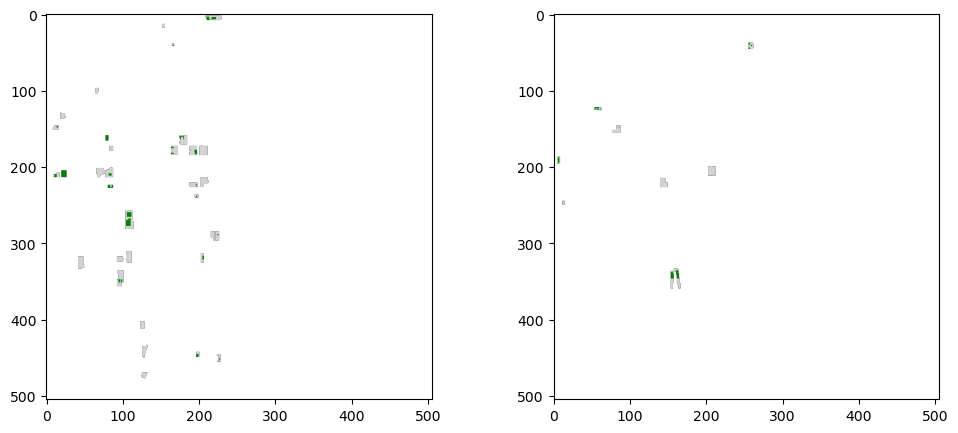

In [54]:
fig, ax = plt.subplots(1,2, figsize = (12,5))
r.plot.show(y_train_image, ax = ax[0], cmap = cmap, vmin = 0, vmax = 2)
r.plot.show(y_test_image, ax = ax[1], cmap = cmap,  vmin = 0, vmax = 2)

## Cross Validation

In [55]:

cv = StratifiedKFold(n_splits=5, shuffle=False)

# param_grid = {
#             'n_estimators': [100, 200, 500],
#             'max_features': ['sqrt', 'log2'],
#             'criterion': ['gini', 'entropy'],
#             # 'max_depth': [20, 30, 50, 100, 200],
#             # 'min_samples_split': [5,10, 20],
       
#             # 'min_samples_leaf': randint(1, 20),
#             'max_leaf_nodes': [5, 10, 20, 40], # Include None as an option
#             # 'min_impurity_decrease': [0.001, 0.005, 0.01, 0.03, 0.05], # Small values, can be more specific like [0.0, 0.001, 0.005]
#             'bootstrap': [True,False],
#             # 'min_samples_leaf': [25, 50],
#             'class_weight': ['balanced', 'balanced_subsample' ,None]
#         }

param_grid = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'criterion': ['gini', 'entropy'],
    'max_depth': [10, 20, 30, None], # Added max_depth
    'min_samples_split': [2, 5, 10], # Added min_samples_split
    'min_samples_leaf': [1, 2, 4],  # Added min_samples_leaf
    'max_leaf_nodes': [10, 20, 40, None], # Adjusted max_leaf_nodes for broader search including None
    'min_impurity_decrease': [0.0, 0.001, 0.01], # Added min_impurity_decrease
    'class_weight': ['balanced', 'balanced_subsample', None],
    'bootstrap': [True, False], # Added bootstrap
    # 'oob_score': [True] # You can include this if you want to explicitly check OOB score during grid search
}

cv_search = search_parameters(
    classification_method = 'RandomForest',
    X_train = X_train_res,
    y_train = y_train_res,
    param_grid=param_grid,
    cv=cv,
    scoring = 'f1',
    search_method = 'random'
    
)

Performing Random Search with Classifier: Random Forest Classifier
Parameter Grid:
n_estimators: [100, 200, 500]
max_features: ['sqrt', 'log2']
criterion: ['gini', 'entropy']
max_depth: [10, 20, 30, None]
min_samples_split: [2, 5, 10]
min_samples_leaf: [1, 2, 4]
max_leaf_nodes: [10, 20, 40, None]
min_impurity_decrease: [0.0, 0.001, 0.01]
class_weight: ['balanced', 'balanced_subsample', None]
bootstrap: [True, False]
Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5; 1/10] START bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=2, n_estimators=500
[CV 1/5; 1/10] END bootstrap=True, class_weight=balanced_subsample, criterion=entropy, max_depth=10, max_features=sqrt, max_leaf_nodes=None, min_impurity_decrease=0.0, min_samples_leaf=2, min_samples_split=2, n_estimators=500;, score=(train=0.959, test=0.797) total time=   2.3s
[CV 2/5; 1/1

## Model Assessment

In [56]:
cl = cv_search.best_estimator_
y_pred = cl.predict(X_test_res)
y_proba = cl.predict_proba(X_test_res)
metrics = compute_metrics(y_test_res,y_pred,list(y_proba), y_labels.values())

In [57]:
print(metrics['report'])

              precision    recall  f1-score   support

        roof       0.88      0.82      0.85       502
  green_roof       0.83      0.89      0.86       502

    accuracy                           0.86      1004
   macro avg       0.86      0.86      0.86      1004
weighted avg       0.86      0.86      0.86      1004



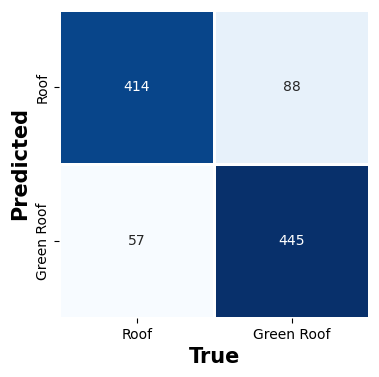

In [58]:

cm = plot_confusion_matrix(
    y_test_res,
    y_pred,
    title ='',
    labels=['Roof', 'Green Roof'],
    figsize = (4,4), 
    out_file='../figures/cm.png'

)


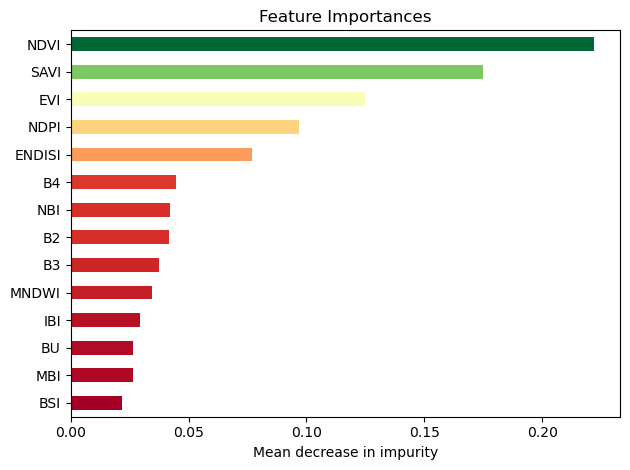

In [59]:



ft = plot_feature_importances(
    rf = cl,
    title = 'Feature Importances',
    features = feature_names,

    out_file =None
)

plt.savefig('../figures/fi.png')

## Classify Green Roofs

In [60]:
X = np.append(X_train, X_test, axis = 0)
y = np.append(y_train, y_test, axis = 0)
cl.fit(X,y)

RandomForestClassifier(class_weight='balanced_subsample', criterion='entropy',
                       max_depth=10, min_samples_leaf=2, n_estimators=500)

In [61]:
# import rioxarray as rio
# import geopandas as gpd
# from matplotlib.pyplot import imshow
# from scipy.ndimage import median_filter
# import matplotlib.pyplot as plt

# from matplotlib.colors import ListedColormap, BoundaryNorm
# import numpy as np

# gdf = gpd.read_file('../data/prc/bldg_class.geojson')

# gt = rio.open_rasterio('../data/prc/bldg_groof_groundtruth.tif')

# evi=rio.open_rasterio(EVI_MEDIAN)
# ndpi=rio.open_rasterio(NDPI_MEDIAN)
# bu=rio.open_rasterio(BU_MEDIAN)
# ndvi=rio.open_rasterio(NDVI_MEDIAN)
# s2 = rio.open_rasterio(S2_MEDIAN).sel(band=slice(1,11))

# import xarray as xr

# evi.name ='evi'
# ndpi.name = 'ndpi'
# bu.name = 'bu'
# ndvi.name = 'ndvi'
# s2.name = 's2'

# X_da = [s2.sel(band = b).rename(feature_names[b-1]) for b in range(1, 4)]
# X_da.extend([evi, bu, ndvi, ndpi])

# X_da_names = feature_names[0:3]
# X_da_names.extend( ['evi','bu','ndvi', 'ndpi'])

# # ndbi.name = 'ndbi'
# X = xr.merge(X_da)

# # idx = np.random.randint(0,len(gdf) - 1 )
# groof1 = gdf.iloc[idx]
# X_clip= X.rio.clip([groof1.geometry]).sel(band=1)
# X_clip = X_clip.where(X_clip != -np.inf)
# X_stack = np.array([X_clip[var].values for var in X_da_names])

# X_bldg = predictor_stack(X_stack)
# org_shape = X_stack.shape[1:]
# img_mask = X_stack != -np.inf
# empty = np.zeros(X_stack.shape[1:])


# groof_predict = cl.predict(X_bldg).reshape(org_shape)
# groof_proba =cl.predict_proba(X_bldg)[:,1].reshape(org_shape)
# gt_bldg = gt.rio.clip([groof1.geometry]).sel(band=1).fillna(0.0).values
# gt_bldg[gt_bldg == np.nan] = 0.0



# width, height = groof_predict.shape
# kernel_size = (np.array(groof_proba.shape ) / 3).astype(int)
# kernel_size[kernel_size < 2] = 3


# fig ,ax = plt.subplots(2,5, figsize = (12,6))



# # Example: 0 = background, 1 = roof, 2 = green roof
# cmap = ListedColormap(['black', 'lightgrey', 'green'])

# # groof_proba_smooth = median_filter(groof_proba, size=(5,5))
# groof_proba_smooth = gaussian_filter(groof_proba, sigma=1)
# # smooth_proba_thresh = np.percentile(groof_proba_smooth, q = 95)
# smooth_proba_thresh = np.float32(0.5)
# groof_proba_classified=  np.where(groof_proba_smooth > smooth_proba_thresh, 2,1)


# ## PLOT GROUND TRUTH AND PREDICTION
# bounds=[0,1, 2, 3]
# norm = BoundaryNorm(bounds, cmap.N)
# ax[0][0].imshow(gt_bldg.astype(int), cmap = cmap, norm = norm, interpolation='nearest',  origin='upper')
# ax[0][1].imshow(groof_predict.astype(int), cmap=cmap, norm = norm, interpolation='nearest', origin='upper')
# ax[0][2].imshow(groof_proba, cmap='viridis',)
# ax[0][3].imshow(groof_proba_smooth, cmap='viridis',)
# ax[0][4].imshow(groof_proba_classified.astype(int), cmap=cmap, norm = norm, interpolation='nearest', origin='upper')


# ## CALCULATION % OVERLAP WITH GROUND TRUTH
# total = gt_bldg.size
# true_px = (gt_bldg == groof_predict).sum()
# pct_true = round(true_px / total, 2)
# md_true_px = (gt_bldg == groof_proba_classified).sum()
# md_pct_true = round(md_true_px / total, 2)
# cl_groof = ((gt_bldg == 2 ) & (groof_predict == 2)).ravel().sum() / (gt_bldg == 2 ).ravel().sum()
# cl_f_groof = ((gt_bldg == 2 ) & (groof_proba_classified == 2)).ravel().sum() / (gt_bldg == 2 ).ravel().sum()

# ## PLOT GROUND TRUTH AND PREDICTION

# ax[0][0].set_title('Ground Truth')
# ax[0][1].set_title(f'RF Prediction ({round(pct_true * 100,1)}%)')
# ax[0][2].set_title('RF Probability')
# ax[0][3].set_title(f'RF Proba Median Filter')
# ax[0][4].set_title(f'Classified \n Median Filter ({round(md_pct_true * 100,1)}%) \n thresh = {smooth_proba_thresh.round(2)}')

# ax[1][0].imshow(X_clip.ndvi, cmap = 'hot',  vmin = ndvi.where(ndvi != -np.inf).min(), vmax = ndvi.where(ndvi != -np.inf).max())
# ax[1][1].imshow(X_clip.evi, cmap = 'hot',  vmin = evi.where(evi != -np.inf).min(), vmax = evi.where(evi != -np.inf).max())
# ax[1][2].imshow(X_clip.bu, cmap = 'hot' , vmin = bu.where(bu != -np.inf).min(), vmax = bu.where(bu != -np.inf).max())
# ax[1][3].imshow(X_clip.ndpi, cmap = 'hot', vmin = ndpi.where(ndpi != -np.inf).min(), vmax = ndpi.where(ndpi != -np.inf).max())
# ax[1][4].imshow(X_clip.B4, cmap = 'hot' , vmin = 0, vmax =1)
# # ax[1][5].imshow(X_clip.B2, cmap = 'RdYlBu' )

# ax[1][0].set_title('NDVI')
# ax[1][1].set_title('EVI')
# ax[1][2].set_title('BUI')
# ax[1][3].set_title('NDPI')
# ax[1][4].set_title('B4')


# for axi in ax.ravel():
#     axi.set_xticks([])
#     axi.set_yticks([])

# plt.tight_layout()
# # plt.savefig('../figures/roof_classification.png')